In [34]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

In [35]:
criteria_name = 'beh_low'

In [36]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/scratch/combined/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

In [37]:
for col, cfg in constraints.items():
    if col not in combined_tagged_units.columns:
        continue

    # Numeric range?
    if "bounds" in cfg:
        print(f'Applying bounds for {col}: {cfg["bounds"]}')
        lb, ub = np.array(cfg["bounds"], dtype=float)  # np.nan for null
        if not np.isnan(lb):
            mask &= combined_tagged_units[col] >= lb
        if not np.isnan(ub):
            mask &= combined_tagged_units[col] <= ub

    # Categorical list?
    elif "items" in cfg:
        print(f'Applying items for {col}: {cfg["items"]}')
        allowed = cfg["items"]
        mask &= combined_tagged_units[col].isin(allowed)

# apply and get filtered DataFrame
combined_tagged_units_filtered = combined_tagged_units[mask].reset_index(drop=True)
combined_tagged_units['selected'] = mask
print(f'Number of units after filtering: {len(combined_tagged_units_filtered)}')
# Save the filtered units
with open(os.path.join(beh_folder, f'filtered_units_{criteria_name}.pkl'), 'wb') as f:
    pickle.dump(combined_tagged_units_filtered, f)


Applying bounds for isi_violations: [0.0, 0.5]
Applying bounds for p_max: [0.5, 1.0]
Applying bounds for lat_max_p: [0.005, 0.02]
Applying bounds for eu: [0.0, 0.25]
Applying bounds for corr: [0.95, 1.0]
Applying items for qc_pass: [True]
Applying bounds for peak: [-1000, 0]
Applying bounds for trial_count: [100, 2000]
Applying items for in_df: [True]
Number of units after filtering: 147


In [38]:
def regressors_to_formula(response_var, regressors):
    terms = [r for r in regressors if r != 'Intercept']
    has_intercept = 'Intercept' in regressors
    rhs = '1' if has_intercept else '0'
    if terms:
        rhs += ' + ' + ' + '.join(terms)
    return f'{response_var} ~ {rhs}'

In [39]:
# get all t-stats, coeffs, p-values for the two groups
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
all_coefs = []
all_T = []
all_p = []
align_name = 'response'
regressors_focus = ['Qchosen', 'outcome', 'ipsi', 'outcome:ipsi']
regressors_sup = ['amp_abs','Intercept', 'motion_abs']
all_regressors = regressors_focus + regressors_sup
formula = regressors_to_formula('spikes', all_regressors)

curr_session = None
pre_event = -1.5
post_event = 3
model_name = 'stan_qLearning_5params'
binSize = 1.5
loaded_session = None
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    # check if different session
    if loaded_session is None or curr_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session, model_name = model_name)
        session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    if 'amp_abs' in all_regressors or 'amp' in all_regressors:
        # get unit_trial_drift_curr's rows corresponding to the ones in session_df_curr
        session_df_curr = session_df_curr.merge(unit_trial_drift_curr, on='trial_ind', how='left').copy()
    if align_name == 'go_cue':
        align_time = session_df_curr['go_cue_time'].values
        # align_time_all = tblTrials_curr['goCue_start_time'].values
    elif align_name == 'response':
        align_time = session_df_curr['choice_time'].values
        # align_time_all = tblTrials_curr['reward_outcome_time'].values
    # spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spike_matrix_LM, slide_times_LM = get_spike_matrix(spike_times_curr, align_time, 
                                                pre_event=pre_event, post_event=post_event, 
                                                binSize=binSize, stepSize=0.25)
    # spike_matrix_all, slide_times = get_spike_matrix(spike_times_curr, align_time_all, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spike_matrix_LM = zscore(spike_matrix_LM, axis=0)  
    
        
    # try:
    regressors, curr_T, curr_p, curr_coefs = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
    # pick regressors from regressors_focus list, sort them according to sequence in regressors_focus
    focus_ind = [regressors.index(r) for r in regressors_focus if r in regressors]
    curr_T = [T_t[focus_ind] for T_t in curr_T]
    curr_p = [p_t[focus_ind] for p_t in curr_p]
    curr_coefs = [coef_t[focus_ind] for coef_t in curr_coefs] 

    if len(curr_T) == 4:
        print(f'Session: {session}, Unit: {unit_id}')

    all_coefs.append(curr_coefs)
    all_T.append(curr_T)
    all_p.append(curr_p)

In [40]:
all_coefsm = np.array(all_coefs)
all_Tm = np.array(all_T)
all_pm = np.array(all_p)

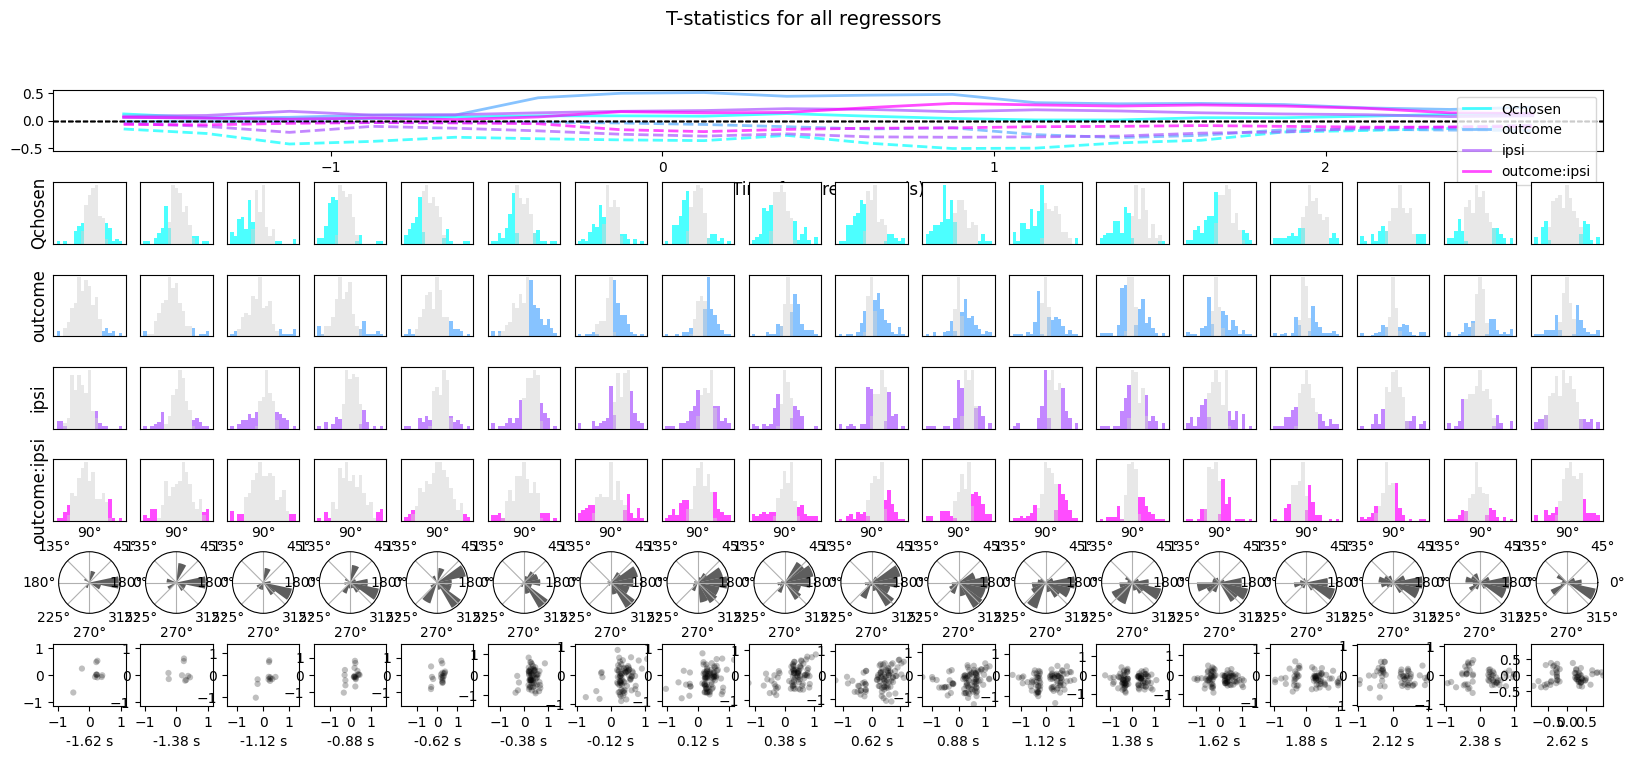

In [41]:
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(len(regressors_focus)+3, len(slide_times_LM), figure=fig, hspace=0.5)
cmap = plt.cm.cool  # Get the colormap
colors = cmap(np.linspace(0, 1, len(regressors_focus)))
ax_all = fig.add_subplot(gs[0, :]) 
for reg_ind, regressor in enumerate(regressors_focus):
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[reg_ind+1, time_ind])
        curr_Ts = all_Tm[:, time_ind, reg_ind]  # get the T-statistics for the current regressor and time
        curr_Ps = all_pm[:, time_ind, reg_ind]  # get the p-values for the current regressor and time
        bins = np.linspace(np.nanmin(curr_Ts)-0.01, np.nanmax(curr_Ts)+0.01, 20)
        ax.hist(curr_Ts[curr_Ps<0.05], bins=bins, color=colors[reg_ind], alpha=0.7, edgecolor='none')  # plot T-statistics with p<0.05
        ax.hist(curr_Ts[curr_Ps>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
        if time_ind == 0:
            ax.set_ylabel(f'{regressor}', fontsize=12)
        # turn off y-ticks and x-ticks
        ax.set_yticks([])
        ax.set_xticks([])

    curr_Ps = np.squeeze(all_pm[:, :, reg_ind])
    curr_Ts = all_Tm[:, :, reg_ind]
    # check if any p-values are below 0.05
    curr_Ps_sig_pos = np.nanmean((curr_Ps<0.05)&(curr_Ts>0), axis = 0) 
    curr_Ps_sig_neg = -np.nanmean((curr_Ps<0.05)&(curr_Ts<0), axis = 0)   
    ax_all.plot(slide_times_LM, curr_Ps_sig_pos, color=colors[reg_ind], alpha=0.7, linewidth=2, label=regressor)  # plot the proportion of significant p-values over time
    ax_all.plot(slide_times_LM, curr_Ps_sig_neg, color=colors[reg_ind], alpha=0.7, linewidth=2, linestyle='--')  # plot the proportion of significant p-values over time
    ax_all.legend(loc='upper right', fontsize=10)
    ax_all.set_xlabel(f'Time from {align_name} (s)', fontsize=12)
    ax_all.axhline(0, color='k', linestyle='--', linewidth=1)  # add a horizontal line at y=0

reward_ind = np.where(np.array(regressors_focus) == 'outcome')[0][0]  # find the index of the reward outcome
q_ind = np.where(np.array(regressors_focus) == 'Qchosen')[0][0]  # find the index of the Qchosen
for time_ind, time in enumerate(slide_times_LM):
    ax = fig.add_subplot(gs[-1, time_ind])
    curr_T_reward = all_Tm[:, time_ind, reward_ind]  # get the T-statistics for the reward outcome
    curr_T_q = all_Tm[:, time_ind, q_ind]  # get the T-statistics for the Qchosen
    curr_coefs_reward = all_coefsm[:, time_ind, reward_ind]  # get the coefficients for the reward outcome
    curr_coefs_q = all_coefsm[:, time_ind, q_ind]  # get the coefficients for the Qchosen
    curr_p_reward = all_pm[:, time_ind, reward_ind]  # get the p-values for the reward outcome
    ax.scatter(curr_coefs_reward[curr_p_reward<0.05], curr_coefs_q[curr_p_reward<0.05], alpha=0.25, color='k', edgecolors='none', s=20)
    ax.set_xlabel(f'{time:.2f} s')
    limit = np.max([np.nanmax(np.abs(curr_coefs_reward)), np.nanmax(np.abs(curr_coefs_q))])
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)

    # polar

    all_vec = np.column_stack((curr_coefs_reward[curr_p_reward<0.05], curr_coefs_q[curr_p_reward<0.05]))  # combine the coefficients for the reward outcome and Qchosen]))

    # Convert Cartesian coordinates to polar coordinates
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])

    # Define histogram edges (bins) from -π to π
    edges = np.linspace(-np.pi, np.pi, 4*4)

    # Create polar histogram
    ax = fig.add_subplot(gs[-2, time_ind], polar=True)
    ax.hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=True)
    ax.set_yticks([])

plt.suptitle('T-statistics for all regressors', fontsize=14)
plt.savefig(os.path.join(beh_folder, f'Regression_in_time_{criteria_name}.pdf'), bbox_inches='tight')


In [42]:
# perform auc on sliding window and define best window for each unit
pre_event = -2
post_event = 5
binSize = 1
auc_mat = []
auc_max = []
auc_max_ind = []
labels = ['outcome', 'ipsi']
loaded_session = None
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']                           
    unit_id = row['unit']
    print(session)
    
    if loaded_session is None or curr_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session, model_name = model_name)
        session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    align_time = session_df_curr['choice_time'].values + 0.2
    spike_matrix_auc, slide_times_auc = get_spike_matrix(spike_times_curr, align_time, 
                                                pre_event=pre_event, post_event=post_event, 
                                                binSize=binSize, stepSize=0.25)
    curr_auc = np.full((len(slide_times_auc), len(labels)), np.nan, dtype=float)
    for time_ind, time in enumerate(slide_times_auc):
        # get the spike counts in the sliding window
        spike_counts = spike_matrix_auc[:, time_ind]
        # outcome
        for label_ind, label in enumerate(labels):
            focus = session_df_curr[label].values
            curr_auc[time_ind, label_ind] = roc_auc_score(focus, spike_counts)
    
    curr_max_ind = np.nanargmax(np.abs(curr_auc-0.5), axis=0)
    curr_max = curr_auc[curr_max_ind, np.arange(len(labels))]

    auc_mat.append(curr_auc)
    auc_max.append(curr_max)
    auc_max_ind.append(curr_max_ind)

behavior_716325_2024-05-31_10-31-14
behavior_716325_2024-05-31_10-31-14
behavior_716325_2024-05-31_10-31-14
behavior_717121_2024-06-15_10-00-58
behavior_717121_2024-06-15_10-00-58
behavior_751004_2024-12-19_11-50-37
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-22_13-09-17
behavior_751004_2024-12-23_14-20-03
behavior_751004_2024-12-23_14-20-03
behavior_751004_2024-12-23_14-20-03
behavior_751004_2024-12-23_14-20-03
behavior_751004_2024-12-23_14-20-03
behavior_751769_2025-01-16_11-32-05
behavior_751769_2025-01-16_1

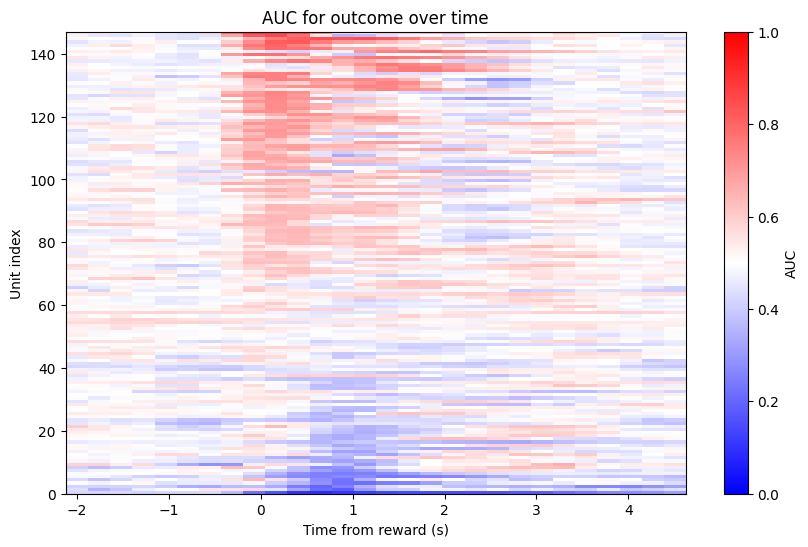

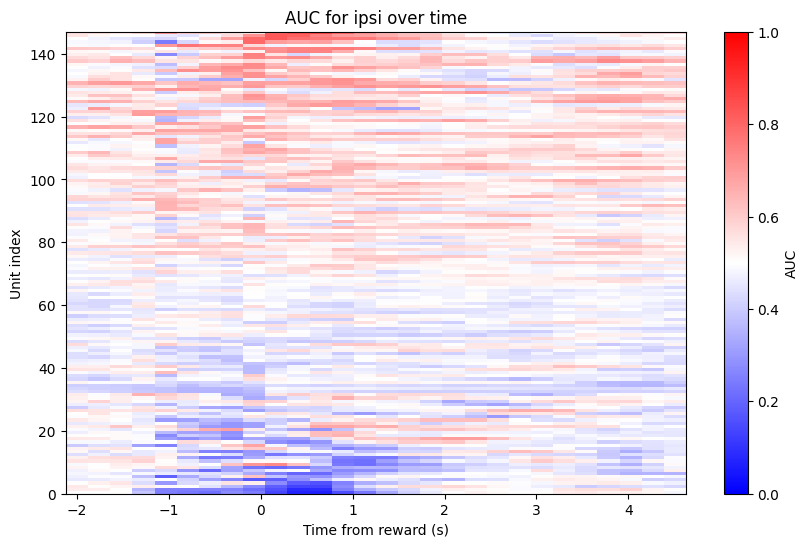

In [43]:
# Define custom colormap: white at 0, blue midrange, red at 1
custom_cmap = LinearSegmentedColormap.from_list(
    'blue_white_red', [(0.0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)

auc_mat = np.array(auc_mat)
auc_max = np.array(auc_max)
auc_max_ind = np.array(auc_max_ind)
for label_ind, label in enumerate(labels):
    plt.figure(figsize=(10, 6))
    sort_ind = np.argsort(auc_max[:, label_ind], axis=0)
    plt.imshow(auc_mat[sort_ind, :, label_ind], aspect='auto', origin='lower', 
               extent=[slide_times_auc[0], slide_times_auc[-1], 0, len(combined_tagged_units_filtered)], 
               cmap=custom_cmap, vmin=0, vmax=1)
    plt.colorbar(label='AUC')
    plt.title(f'AUC for {label} over time')
    plt.xlabel('Time from reward (s)')
    plt.ylabel('Unit index')
    plt.savefig(os.path.join(beh_folder, f'AUC_{label}_{criteria_name}.pdf'), bbox_inches='tight')

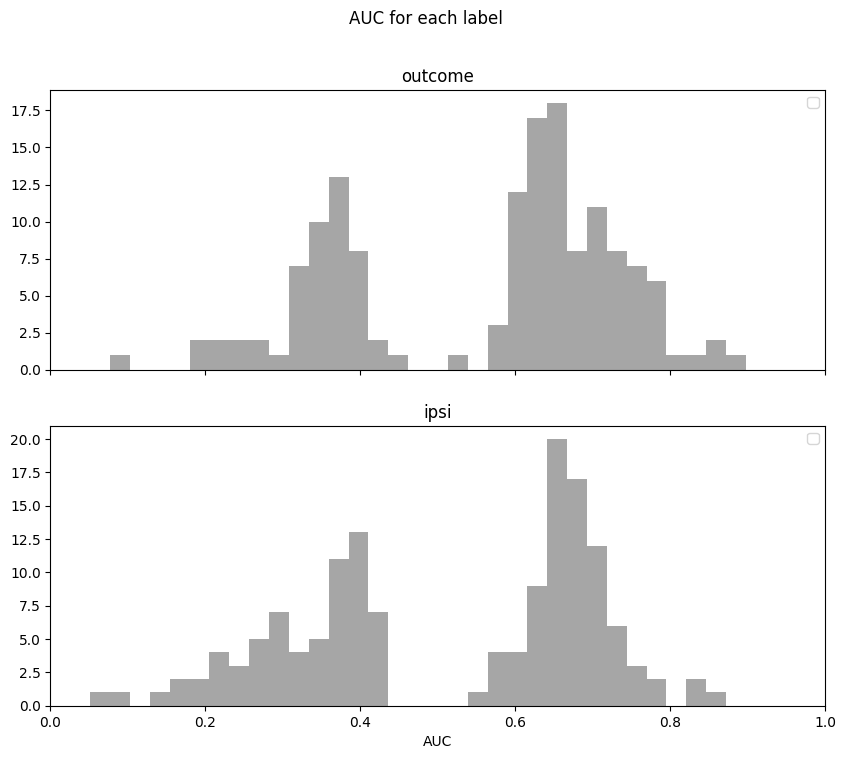

In [44]:
fig, axes = plt.subplots(len(labels), 1, figsize=(10, 8), sharex=True)
bins = np.linspace(0, 1, 40)
for label_ind, label in enumerate(labels):
    axes[label_ind].hist(auc_max[:, label_ind], bins=bins, color='gray', alpha=0.7, edgecolor='none')
    axes[label_ind].set_title(f'{label}')
    axes[label_ind].legend()
    axes[label_ind].set_xlim(0, 1)
plt.xlabel('AUC')
plt.suptitle('AUC for each label')
plt.savefig(os.path.join(beh_folder, f'AUC_hist_{criteria_name}.pdf'), bbox_inches='tight')

In [58]:
#use the max auc window to re-do regression
focus_label = 'outcome'
all_coefs = []
all_T = []
all_p = []
align_name = 'response'
regressors_focus = ['Qchosen', 'outcome', 'ipsi', 'outcome:ipsi']
regressors_sup = ['amp_abs','Intercept', 'motion_abs']
all_regressors = regressors_focus + regressors_sup
formula = regressors_to_formula('spikes', all_regressors)
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    # check if different session
    if loaded_session is None or curr_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session, model_name = model_name)
        session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    if 'amp_abs' in all_regressors or 'amp' in all_regressors:
        # get unit_trial_drift_curr's rows corresponding to the ones in session_df_curr
        session_df_curr = session_df_curr.merge(unit_trial_drift_curr, on='trial_ind', how='left').copy()
    curr_max_ind = auc_max_ind[ind, labels.index(focus_label)]
    align_time_max = slide_times_auc[curr_max_ind]
    align_time = session_df_curr['choice_time'].values + 0.2
    align_time_cue = session_df_curr['go_cue_time'].values
    spike_df = align.to_events(spike_times_curr, align_time + align_time_max, [-0.75, 0.75], return_df=True)
    counts = spike_df.groupby('event_index').size()
    counts = [counts.get(i, 0) for i in range(len(session_df_curr))]
    baseline_df = align.to_events(spike_times_curr, align_time_cue, [-1, 0], return_df=True)
    counts_bl = baseline_df.groupby('event_index').size()
    counts_bl = [counts_bl.get(i, 0) for i in range(len(session_df_curr))]
    # counts = np.array(counts) - np.array(counts_bl)
    spike_matrix_LM = np.reshape(np.array([counts]), (-1, 1))
    spike_matrix_LM = zscore(spike_matrix_LM, axis=0)  
        
    # try:
    regressors, curr_T, curr_p, curr_coefs = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
    # pick regressors from regressors_focus list, sort them according to sequence in regressors_focus
    focus_ind = [regressors.index(r) for r in regressors_focus if r in regressors]
    curr_T = [T_t[focus_ind] for T_t in curr_T] 
    curr_p = [p_t[focus_ind] for p_t in curr_p]
    curr_coefs = [coef_t[focus_ind] for coef_t in curr_coefs]

    all_coefs.append(curr_coefs)
    all_T.append(curr_T)
    all_p.append(curr_p)

In [59]:
all_coefsm = np.squeeze(np.array(all_coefs))
all_Tm = np.squeeze(np.array(all_T))
all_pm = np.squeeze(np.array(all_p))

In [60]:
# scatter and polar of 'outcome' and 'Qchosen'
inter_ind = np.where(np.array(regressors_focus) == 'outcome:ipsi')[0][0]  # find the index of the intercept
outcome_ind = np.where(np.array(regressors_focus) == 'outcome')[0][0]  # find the index of the reward outcome
q_ind = np.where(np.array(regressors_focus) == 'Qchosen')[0][0]  # find the index of the Qchosen
curr_coefs_outcome = all_coefsm[:, outcome_ind]  # get the coefficients for the reward outcome4
curr_coefs_q = all_coefsm[:, q_ind]  # get the coefficients for the Qchosen
curr_coefs_int = all_coefsm[:, inter_ind]  # get the coefficients for the interaction
curr_T_outcome = all_Tm[:, outcome_ind]  # get the T-statistics for the reward outcome
curr_T_q = all_Tm[:, q_ind]  # get the T-statistics for the Qchosen
curr_p_outcome = all_pm[:, outcome_ind]  # get the p-values for the reward outcome
curr_p_int = all_pm[:, inter_ind]  # get the p-values for the Qchosen

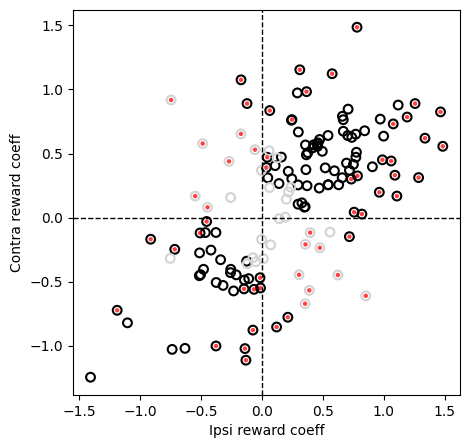

In [61]:
# compare ipsi vs contra responses
ipsi_reward_coeff = curr_coefs_outcome + curr_coefs_int
contra_reward_coeff = curr_coefs_outcome - curr_coefs_int

# scatter
plt.figure(figsize=(5, 5))
plt.scatter(ipsi_reward_coeff[curr_p_outcome<0.05], contra_reward_coeff[curr_p_outcome<0.05], 
            alpha=1, edgecolors='k', color='none', s=40, linewidths=1.5)
plt.scatter(ipsi_reward_coeff[curr_p_outcome>=0.05], contra_reward_coeff[curr_p_outcome>=0.05],
            alpha=1, edgecolors='lightgray', color='none', s=40, linewidths=1.5)
mask = curr_p_int<0.05
plt.scatter(ipsi_reward_coeff[mask], contra_reward_coeff[mask],
            alpha=0.75, edgecolors='none', color='red', s=10)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Ipsi reward coeff')
plt.ylabel('Contra reward coeff')
plt.savefig(os.path.join(beh_folder, f'ipsi_vs_contra_reward_coeff_{criteria_name}.pdf'), bbox_inches='tight')

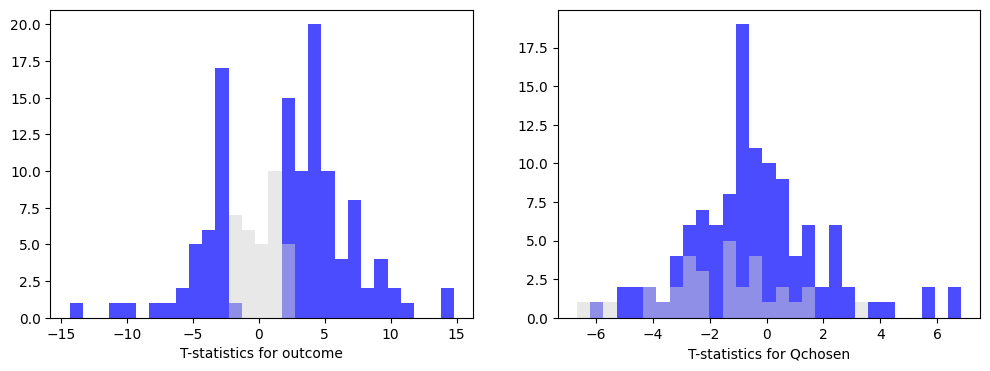

In [62]:
# histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
bins = np.linspace(np.nanmin(curr_T_outcome)-0.01, np.nanmax(curr_T_outcome)+0.01, 30)
plt.hist(curr_T_outcome[curr_p_outcome<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
plt.hist(curr_T_outcome[curr_p_outcome>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
plt.xlabel('T-statistics for outcome')

plt.subplot(1, 2, 2)
bins = np.linspace(np.nanmin(curr_T_q)-0.01, np.nanmax(curr_T_q)+0.01, 30)
plt.hist(curr_T_q[curr_p_outcome<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
plt.hist(curr_T_q[curr_p_outcome>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
plt.xlabel('T-statistics for Qchosen')
plt.savefig(os.path.join(beh_folder, f'T_statistics_outcome_Qchosen_focus_wind_{criteria_name}.pdf'), bbox_inches='tight')


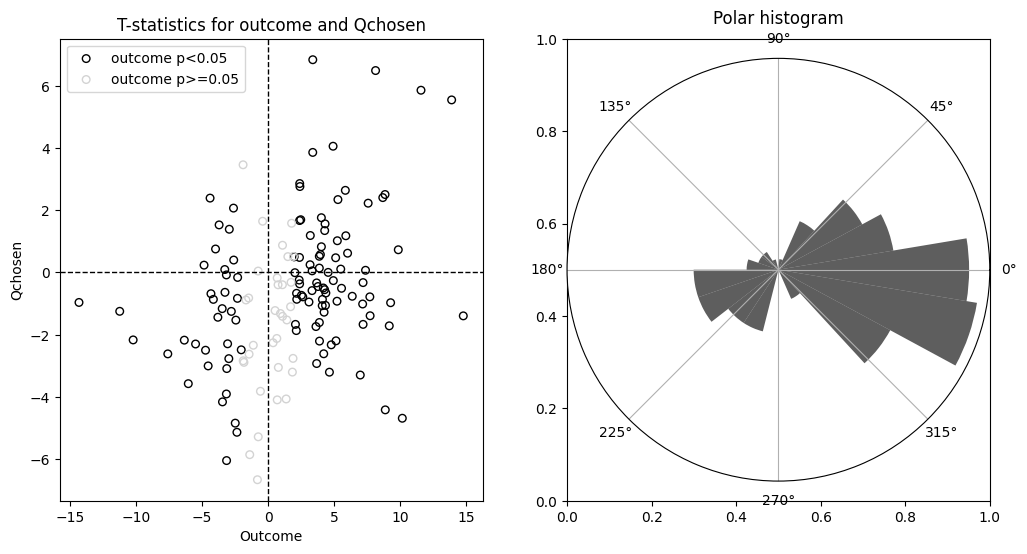

In [66]:
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(curr_T_outcome[curr_p_outcome<0.05], curr_T_q[curr_p_outcome<0.05], color='none', edgecolors='k', s=30, label = 'outcome p<0.05')
axes[0].scatter(curr_T_outcome[curr_p_outcome>=0.05], curr_T_q[curr_p_outcome>=0.05], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# polar
thresh = 0.05
all_vec = np.column_stack((curr_coefs_outcome[curr_p_outcome<thresh], curr_coefs_q[curr_p_outcome<thresh]))  # combine the coefficients for the reward outcome and Qchosen
# Convert Cartesian coordinates to polar coordinates
theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
# Define histogram edges (bins) from -π to π
edges = np.linspace(-np.pi, np.pi, 4*5)
# Create polar histogram
axes[1] = fig.add_subplot(122, polar=True)
axes[1].hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=False)
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
# plt.suptitle('Outcome and Qchosen coefficients', fontsize=16)
plt.savefig(os.path.join(beh_folder, f'Summary_outcome_Qchosen_coeffs_{criteria_name}.pdf'), bbox_inches='tight')

In [64]:
# make a df from all_Tm, columns correspond to focus regressors 
all_Tm_df = pd.DataFrame(all_Tm, columns=[regressor + '_T' for regressor in regressors_focus])
all_pm_df = pd.DataFrame(all_pm, columns=[regressor + '_p' for regressor in regressors_focus])
all_coefsm_df = pd.DataFrame(all_coefsm, columns=[regressor + '_coef' for regressor in regressors_focus])
model_combined = pd.concat([combined_tagged_units_filtered[['session', 'unit']], all_Tm_df, all_pm_df, all_coefsm_df], axis=1)

In [65]:
model_combined.to_csv(os.path.join(beh_folder, f'model_combined_{criteria_name}.csv'), index=False)